# Projekt zaliczeniowy

Uczelnia: Uniwersytet Ekonomiczny we Wrocławiu
<br>Kierunek: Informatyka w Biznesie
<br>II rok magisterskich studiów niestacjonarnych
<br>Przedmiot: Data Science
<br>
<br>Autor: Tomasz Kubicz
<br>Numer indeksu: 172780

# 1. Wstęp

Jako naczelne założenie projektu przyjęto, że polegać ma on na stworzeniu (przy pomocy technik uczenia maszynowego) modelu, który mógłby realizować potrzebę biznesową występującą w realnych warunkach rynkowych. 
<br><br>Projekt został wykonany w oparciu o zbiór danych załączony do książki "Data Analysis Using SQL and Excel" napisanej przez Gordona Linoffa. 
<br><br>Model predykcyjny utworzony w dalszej części projektu ma za zadanie wspierać proces zarządzania retencją klientów poprzez identyfikowanie tych klientów, dla których istnieje wysokie prawdopodobieństwo, że odejdą one od usług firmy, na danych której model się uczył.
<br><br>Tak jak zawarto w wymaganiach projektu przedstawionych przez prowadzącego, w projekcie ograniczono analizę "ogólną" danych, która była przedmiotem wcześniejszego projektu zaliczeniowego, i skupiono się na samym procesie tworzenia modelu z ograniczoną rolą wizualizacji.

# 2. Konfiguracja projektu oraz import bibliotek pomocniczych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

%matplotlib inline

# 3. Dane

Struktura tabel wykorzystanych w projekcie została przedstawiona w podanej wcześniej książce (strona 7) w formie poniższego schematu. Między schematem a fizycznymi plikami istnieje kilka różnic - tabele "Customer", "OrderLine" i "Product" w plikach występują pod nazwami odpowiednio - "customers", "orderlines", "products".

<img src="relationship-schema.jpg" style="height:350px">

Nie wykorzystano wszystkich z dostępnych tabel. Lista tabel wykorzystanych:
<br> - Customers
<br> - Campaigns
<br> - Orders
<br> - OrderLines
<br> - Products
<br><br> W kolejnych podpunktach wczytano kolejne pliki tekstowe jako obiekty dataframe pochodzące z biblioteki pandas.

## 3.1 Tabele 

Poniżej przedstawiono podgląd danych umieszczonych w tabelach wraz z opisem kolumn

### 3.1.1 Tabela "customers" 

Tabela zawiera informacje o samym kliencie, nie związane z jego zamówieniami.

In [2]:
customers = pd.read_table('customers.txt')
customers.head()

,customerid,householdid,gender,firstname
0,174596,53949999,M,DANIEL
1,68239,49927024,M,JIM
2,10203,20914414,F,DONNA
3,174288,53957047,F,DIONE
4,68099,49927024,M,JIM


Znaczenie kolumn:
<br>- customerid - identyfikator klienta
<br>- householdid - identyfikator gospodarstwa domowego
<br>- gender - płeć
<br>- firstname - imię
<br>
<br>
Jest to zbiór zanonimizowany. Brak jakichkolwiek informacji, które pozwoliłyby na powiązanie klienta przedsiębiorstwa z konkretną osobą fizyczną poza przedsiębiorstwem (występuje tylko identyfikator wewnętrzny przedsiębiorstwa, to jest customerid, brak identyfikatorów zewnętrznych takich jak numer PESEL, nazwisko).

### 3.1.2 Tabela "campaigns" 

Tabela zawiera dane kampanijne.

In [3]:
campaigns = pd.read_table('campaigns.txt')
campaigns.head()

,campaignid,campaignname,channel,discount,freeshippingflag
0,2001,NaN,PARTNER,0,N
1,2002,NaN,AD,0,N
2,2003,NaN,PARTNER,0,N
3,2004,NaN,PARTNER,0,N
4,2005,NaN,PARTNER,0,N


Znaczenie kolumn:
<br>- campaignid - numer identyfikacyjny kampanii 
<br>- campaignname - nazwa kampanii
<br>- channel - kanał kampanii
<br>- udzielona zniżka
<br>- flaga informująca o tym, czy klient otrzymał darmową dostawę

### 3.1.3 Tabela "orders" 

Tabela zawiera dane o zamówieniach.
<br>
<br>W przypadku poniższej tabeli podczas wczytywania danych trzeba było wskazać odpowiednie kodowanie, które jest w stanie obsługiwać zawarte w pliku ciągi znaków.

In [4]:
orders = pd.read_table('orders.txt', encoding='cp1251')
orders.head()

,orderid,customerid,campaignid,orderdate,city,state,zipcode,paymenttype,totalprice,numorderlines,numunits
0,1002854,45978,2141,2009-10-13 00:00:00,NEWTON,MA,02459,VI,190.00,3,3
1,1002855,125381,2173,2009-10-13 00:00:00,NEW ROCHELLE,NY,10804,VI,10.00,1,1
2,1002856,103122,2141,2011-06-02 00:00:00,MIAMI,FL,33137,AE,35.22,2,2
3,1002857,130980,2173,2009-10-14 00:00:00,E RUTHERFORD,NJ,07073,AE,10.00,1,1
4,1002886,48553,2141,2010-11-19 00:00:00,BALTIMORE,MD,21218,VI,10.00,1,1


Znaczenie kolumn:
<br>- orderid - identyfikator zamówienia
<br>- customerid - identyfikator klienta
<br>- campaignid - identyfikator kampanii
<br>- orderdate - data zamówienia
<br>- city - miasto, w którym dokonano zamówienia
<br>- state - stan (obszar administracyjny)
<br>- zipcode - kod pocztowy
<br>- paymenttype - rodzaj zapłaty
<br>- totalprice - całkowita wartość zamówienia
<br>- numunits - liczba jednostek

### 3.1.4 Tabela "products" 

Tabela zawiera dane o produktach.

In [5]:
products = pd.read_table('products.txt')
products.head()

,PRODUCTID,PRODUCTNAME,PRODUCTGROUPCODE,PRODUCTGROUPNAME,INSTOCKFLAG,FULLPRICE
0,10001,NaN,CA,CALENDAR,N,15
1,10002,NaN,CA,CALENDAR,N,10
2,10003,NaN,CA,CALENDAR,N,10
3,10004,NaN,BK,BOOK,Y,90
4,10005,NaN,BK,BOOK,Y,16


Znaczenie kolumn:
<br>- productid - identyfikator produktu
<br>- productname - nazwa produktu
<br>- productgroupcode - kod grupy produktowej
<br>- productgroupname - nazwa grupy produktowej
<br>- instockflag - flaga informująca czy towar jest dostępny na magazynie
<br>- całkowita cena produktu

### 3.1.5 Tabela "orderlines" 

In [6]:
orderlines = pd.read_table('orderlines.txt')
orderlines.head()

,orderlineid,orderid,productid,shipdate,billdate,unitprice,numunits,totalprice
0,1010561,1006414,10834,2011-03-07 00:00:00,2011-03-08 00:00:00,18.00,1,18.00
1,1010562,1006541,11052,2011-01-19 00:00:00,2011-01-20 00:00:00,10.00,2,20.00
2,1010563,1006542,11070,2011-01-19 00:00:00,2011-01-20 00:00:00,19.12,1,19.12
3,1010564,1010154,11196,2009-11-19 00:00:00,2009-11-20 00:00:00,14.95,1,14.95
4,1010565,1009110,11048,2009-11-11 00:00:00,2009-11-12 00:00:00,10.00,2,20.00


Znaczenie kolumn:
<br>- orderlineid - identyfikator wiersza w tabeli orderlines
<br>- productid - identyfikator produktu
<br>- shipdate - data dostawy
<br>- billdate - data rachunku
<br>- unitprice - cena jednostkowa
<br>- numunits - liczba jednostek
<br>- totalprice - całkowita cena 

### 3.2 Obróbka danych

Posiadane dane należy odpowiednio przetworzyć, co zrobiono w krokach przedstawionych niżej.

### 3.2.1 Usunięcie kolumn

Przed rozpoczęciem jakichkolwiek prac na danych, należy usunąć te kolumny, które nie będą wykorzystywane w dalszych pracach. Ma to na celu przyspieszenie obliczeń oraz uniknięcie prac (np. wypełnienie wartości nullowych) na takich danych, które nie są do niczego później potrzebne.

W tabeli 'customers' usunięto kolumnę 'firstname' - imię klienta nie powinno mieć istotnego wpływu na retencję klienta. 
Warto jednak zaznaczyć, że gdybyśmy nie posiadali informacji o płci klienta, warto byłoby sprawdzić i tę zmienną - zachowania osób o imionach żeńskich mogłyby się znacznie różnić od zachowań osób o imionach męskich.

In [7]:
customers2 = customers.drop(columns = 'firstname')

Po sprawdzeniu podejrzanej kolumny 'campaignname' w tabeli 'campaigns' (w wyświetlonych danych nie zauważono żadnej wartości) okazało się, że kolumna jest pusta. Postanowiono ją w takiej sytuacji usunąć.

In [8]:
campaigns['campaignname'].count()

0

In [9]:
campaigns2 = campaigns.drop(columns = 'campaignname')

Jako że w tabeli 'products' występują dwie kolumny oznaczające grupy produktowe (jedna kolumna określa nazwę grupy produktowej, zaś druga kod tej grupy), postanowiono pozostawić tylko jedną z nich (występowanie dwóch skutkowałoby powieleniem tych samych informacji).

In [10]:
products2 = products.drop(columns = 'PRODUCTNAME')

### 3.2.2 Uzupełnienie wartości nullowych

Często w danych można znaleźć braki, tak więc postanowiono sprawdzić możliwość ich wystąpienia w używanych tabelach, a następnie uzupełnić je znanymi metodami.

In [11]:
customers2.isnull().sum()

customerid         0
householdid        0
gender         16204
dtype: int64

W tabeli 'customers2' wykryto braki w kolumnie 'gender'. Przypisano wybrakowanym rekordom płeć z rekordów je bezpośrednio poprzedzających.

In [12]:
customers3 = customers2.fillna(method = 'ffill')
#Sprawdzenie czy aby na pewno wartości zostały uzupełnione
customers3.isnull().sum()

customerid     0
householdid    0
gender         0
dtype: int64

Tabela 'campaigns2' nie zawiera wartości nullowych, co potwierdza poniższy kod:

In [13]:
campaigns2.isnull().sum()

campaignid          0
channel             0
discount            0
freeshippingflag    0
dtype: int64

Zgodnie z poniższym kodem trzy kolumny zawierają braki w danych.

In [14]:
orders.isnull().sum()

orderid             0
customerid          0
campaignid          0
orderdate           0
city               19
state            1119
zipcode           146
paymenttype         0
totalprice          0
numorderlines       0
numunits            0
dtype: int64

Niestety nie można w tej sytuacji uzupełnić danych metodą zastosowaną wcześniej - zbyt duże zróżnicowanie kodów pocztowych, miast i stanów sprawia, że takie rozwiązanie wiązałoby się z bardzo małym prawdopodobieństwem uzupełnienia rekordów prawidłowymi informacjami.

Podobnie jeśli chodzi o tabelę 'products2' i kolumnę 'PRODUCTGROUPNAME'. Na szczęście problem dotyczy tylko jednego rekordu, tak więc nie wpływa to istotnie na całą analizę. 

In [15]:
products2.isnull().sum()

PRODUCTID           0
PRODUCTGROUPCODE    0
PRODUCTGROUPNAME    1
INSTOCKFLAG         0
FULLPRICE           0
dtype: int64

In [16]:
products2.count()

PRODUCTID           4040
PRODUCTGROUPCODE    4040
PRODUCTGROUPNAME    4039
INSTOCKFLAG         4040
FULLPRICE           4040
dtype: int64

W przypadku tabeli 'orderlines' zauważono dość duże braki cen jednostkowych ('unitprice'). W skali całego zbioru dotyczy to zauważalnej liczby rekordów, natomiast w skali 286 017 wszystkich rekordów jest to liczba akceptowalna. 

In [17]:
orderlines.isnull().sum()

orderlineid       0
orderid           0
productid         0
shipdate          0
billdate          0
unitprice      4984
numunits          0
totalprice        0
dtype: int64

In [18]:
orderlines.count()

orderlineid    286017
orderid        286017
productid      286017
shipdate       286017
billdate       286017
unitprice      281033
numunits       286017
totalprice     286017
dtype: int64

Zadecydowano o uzupełnieniu braków medianą ceny jednostkowej.

In [19]:
orderlines2 = orderlines 
orderlines2['unitprice'] = orderlines2['unitprice'].fillna(orderlines['unitprice'].median())
orderlines.isnull().sum()

orderlineid    0
orderid        0
productid      0
shipdate       0
billdate       0
unitprice      0
numunits       0
totalprice     0
dtype: int64

### 3.2.3 Połączenie tabel

Postanowiono utworzyć nową charakterystykę na bazie już istniejących. Jest to jednak utrudnione ze względu na to, że charakterystyki źródłowe znajdują się w innych tabelach. Z tego powodu połączono rozbite tabele w jeden większy dataframe.

Ostateczna lista wykorzystywanych przy łączeniu tabel: 'customers3', 'campaigns2', 'products2', 'orderlines2', 'orders'

In [20]:
main_df = customers3.merge(orders, left_on = 'customerid', right_on = 'customerid', how = 'left') \
    .merge(campaigns2, left_on = 'campaignid', right_on = 'campaignid', how = 'left') \
    .merge(orderlines2, left_on = 'orderid', right_on = 'orderid', how = 'left') \
    .merge(products2, left_on = 'productid', right_on = 'PRODUCTID', how = 'left')

### 3.2.4 Dodanie nowych kolumn

Wykorzystując wiedzę domenową stwierdzono, że istotną cechą utrzymującą klienta powinna być długość czasu zaczynająca się w momencie złożenia zamówienia i kończąca wraz z dostawą towaru. Obliczyć ją można w prosty sposób z istniejących już kolumn, natomiast by dokonać odejmowanie, należy najpierw zrzutować typ kolumn źródłowych z ciągu znaków na datę.

In [21]:
main_df['shipdate'] = pd.to_datetime(main_df['shipdate'])
main_df['orderdate'] = pd.to_datetime(main_df['orderdate'])

Przystąpiono do utworzenia nowej charakterystyki 'shipping_time' mówiącej o czasie dostawy (liczonym od momentu złożenia zamówienia do dostarczenia produktu).

In [22]:
main_df['shipping_time'] = (main_df['shipdate'] - main_df['orderdate']).dt.days

Znajomość danych pozwala stwierdzić, że brak danych w kolumnie 'state' w większości przypadków oznacza, że zamówienie zostało złożone z lokalizacji zagranicznej. Może się to okazać istotną infromacją, dlatego postanowiono utworzyć nową charakterystykę 'abroad'.
Wartości 'abroad': 1 - zamówienie złożone zagranicą, 0 - zamówienie złożone w USA.

In [23]:
main_df['abroad'] = main_df['state'].apply(lambda x: 1 if pd.isnull(x) else 0)

### 3.2.5 Dodanie nowych kolumn (zmienne kategoryczne)

Aby uwzględnić w predykcji dane zawarte w kolumnach o typie tekstowym, utworzono nowe zmienne kategoryczne oparte na flagach. Przykład: jeśli klienci mogli mieć przyznaną płeć męską (znak M) lub żeńską (F), utworzono dwie kolumny przyjmujące wartości 1 lub 0. 1 oznacza, że daną płeć klient przyjął, 0 - nie przyjął. 

In [24]:
encoded_main_df = main_df
gender_dummies = pd.get_dummies(encoded_main_df.gender)
#city_dummies = pd.get_dummies(encoded_main_df.city)
state_dummies = pd.get_dummies(encoded_main_df.state)
#zipcode_dummies = pd.get_dummies(encoded_main_df.zipcode)
freeshippingflag_dummies = pd.get_dummies(encoded_main_df.freeshippingflag) #to nie była flaga - na flagę zamieniono wartości 'Y' i 'N'
channel_dummies = pd.get_dummies(encoded_main_df.channel)
paymenttype_dummies = pd.get_dummies(encoded_main_df.paymenttype)
encoded_main_df = pd.concat([encoded_main_df, gender_dummies, state_dummies, freeshippingflag_dummies, channel_dummies, paymenttype_dummies], axis=1)

Zważywszy na ograniczenia wynikajace z mocy obliczeniowej sprzętu, na którym przygotowywane są dane pod predykcję (utworzenie tylu zmiennych ile występuje w danych miast i kodów pocztowych jest bardzo obciążające), postanowiono zakomentować fragmenty kodu tworzące dummy variables z kolumn związanych z kodami pocztowymi oraz nazwami miast. Jako że lokalizacja może okazać się ważnym elementem predykcji, pozostawiono dane lokalizacyjne na poziomie stanów.

Następnie usunięto kolumny, na podstawie których utworzono dummy variables.

In [25]:
encoded_main_df = encoded_main_df.drop(['gender', 'city', 'state', 'zipcode', 'freeshippingflag', 'channel', 'paymenttype'], axis = 1)

Poniżej podejrzano powstały dataframe.

In [26]:
encoded_main_df

,customerid,householdid,orderid,campaignid,orderdate,totalprice_x,numorderlines,numunits_x,discount,orderlineid,...,PARTNER,REFERRAL,SURVEY,WEB,??,AE,DB,MC,OC,VI
0,174596,53949999,1391159,2204,2015-09-27,44.95,1,1,0,1601228,...,0,1,0,0,0,1,0,0,0,0
1,68239,49927024,1391160,2237,2015-09-24,0.00,1,100,0,1601206,...,0,0,0,0,0,0,1,0,0,0
2,10203,20914414,1391161,2141,2015-09-24,62.05,3,3,10,1601239,...,1,0,0,0,0,0,0,0,0,1
3,10203,20914414,1391161,2141,2015-09-24,62.05,3,3,10,1601240,...,1,0,0,0,0,0,0,0,0,1
4,10203,20914414,1391161,2141,2015-09-24,62.05,3,3,10,1601241,...,1,0,0,0,0,0,0,0,0,1
5,174288,53957047,1391162,2236,2015-09-24,100.00,2,2,0,1601214,...,0,0,0,1,0,0,0,0,0,1
6,174288,53957047,1391162,2236,2015-09-24,100.00,2,2,0,1601215,...,0,0,0,1,0,0,0,0,0,1
7,68099,49927024,1391163,2237,2015-09-24,0.00,2,2,0,1601218,...,0,0,0,0,0,0,1,0,0,0
8,68099,49927024,1391163,2237,2015-09-24,0.00,2,2,0,1601219,...,0,0,0,0,0,0,1,0,0,0
9,174257,53949983,1391164,2236,2015-09-25,89.95,2,2,0,1601122,...,0,0,0,1,0,0,0,0,0,1


Wyciągnięto listę kolumn, która posłuży za bazę pod tworzenie charakterystyk zagregowanych.

In [27]:
list(encoded_main_df)

['customerid',
 'householdid',
 'orderid',
 'campaignid',
 'orderdate',
 'totalprice_x',
 'numorderlines',
 'numunits_x',
 'discount',
 'orderlineid',
 'productid',
 'shipdate',
 'billdate',
 'unitprice',
 'numunits_y',
 'totalprice_y',
 'PRODUCTID',
 'PRODUCTGROUPCODE',
 'PRODUCTGROUPNAME',
 'INSTOCKFLAG',
 'FULLPRICE',
 'shipping_time',
 'abroad',
 'F',
 'M',
 'AA',
 'AE',
 'AK',
 'AL',
 'AP',
 'AR',
 'AZ',
 'BC',
 'CA',
 'CN',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'FR',
 'GA',
 'GU',
 'HI',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'LC',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NF',
 'NH',
 'NJ',
 'NM',
 'NS',
 'NV',
 'NY',
 'OH',
 'OK',
 'ON',
 'OR',
 'PA',
 'PE',
 'PR',
 'RI',
 'SC',
 'SD',
 'SP',
 'TN',
 'TX',
 'US',
 'UT',
 'VA',
 'VI',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY',
 'N',
 'Y',
 'AD',
 'BULK',
 'CATALOG',
 'CONFERENCE',
 'EMAIL',
 'EMPLOYEE',
 'INSERT',
 'INTERNAL',
 'MAIL',
 'PARTNER',
 'REFERRAL',
 'SURVEY',
 'WEB',
 '??',
 'AE'

### 3.5 Agregacja danych

Łącząc wiele tabel w jedną doprowadzono do sytuacji, w której dla jednego klienta może występować wiele rekordów, przykładowo jeden klient mógł złożyć dwa zamówienia, przez co wystąpi w tabeli main_df dwukrotnie. Taka sytuacja w analizie predykcyjnej jest niedopuszczalna i aby rozwiązać ten problem, postanowiono utworzyć nową tabelę zawierającą charakterystyki agregujące dane z różnych rekordów.

In [28]:
agg_main = {
     #'householdid', -- uznano za nieistotne
     'orderid' : {'orderid_count' : 'nunique'},
     'campaignid' : {'campaignid_count' : 'nunique'},
     'orderdate' : {'orderdate_max' : 'max', 'orderdate_min' : 'min'},
     #'city', -- zmienna do przetworzenia na dummy variable
     #'state', -- zmienna przetworzona na dummy variable
     #'zipcode', -- zmienna do przetworzenia na dummy variable
     #'paymenttype',-- zmienna przetworzona na dummy variable 
     'totalprice_x' : {'totalprice_x_sum' : 'sum', 'totalprice_x_min' : 'min', 'totalprice_x_max' : 'max', 
                       'total_price_x_mean' : 'mean'},
     'numorderlines': {'numorderlines_count' : 'nunique'},
     'numunits_x' : {'numunits_x_count' : 'count', 'numunits_x_min' : 'min', 'numunits_x_max' : 'max', 
                     'numunits_x_mean' : 'mean'},
     #'channel', -- zmienna przetworzona na dummy variable
     'discount' : {'discount_max' : 'max', 'discount_mean' : 'mean'},
     'Y' : {'Y_max' : 'max'}, #free shipping flag - YES
     'N' : {'N_max' : 'max'}, #without min because it would duplicate information from 'Y'
     'orderlineid' : {'orderlineid_count' : 'nunique'},
     'productid' : {'productid_count' : 'nunique'},
     'shipdate' : {'shipdate_max' : 'max'},
     'billdate' : {'billdate_max' : 'max'},
     'numunits_y' : {'numunits_y_max' : 'max', 'numunits_y_min' : 'min', 'numunits_y_sum' : 'sum', 'numunits_y_mean' : 'mean'},
     'totalprice_y' : {'totalprice_y_min' : 'min', 'totalprice_y_max' : 'max', 
                       'totalprice_y_mean' : 'mean', 'totalprice_y_sum' : 'sum'},
     'PRODUCTID' : {'PRODUCTID_count' : 'nunique'},
     'PRODUCTGROUPCODE' : {'PRODUCTGROUPCODE_count' : 'nunique'},
     'PRODUCTGROUPNAME' : {'PRODUCTGROUPNAME_count' : 'nunique'},
     'shipping_time' : {'shipping_time_max' : 'max', 'shipping_time_min' : 'min'},
     'abroad' : {'abroad_max' : 'max', 'abroad_min' : 'min'},
     'F' : {'F_max' : 'max'},
     'M' : {'M_max' : 'max'},
     'AA' : {'AA' : 'max'},
     'AK' : {'AK_max' : 'max'},
     'AL' : {'AL_max' : 'max'},
     'AP' : {'AP_max' : 'max'},
     'AR' : {'AR_max' : 'max'},
     'AZ' : {'AZ_max' : 'max'},
     'BC' : {'BC_max' : 'max'},
     'CA' : {'CA_max' : 'max'},
     'CN' : {'CN_max' : 'max'},
     'CO' : {'CO_max' : 'max'},
     'CT' : {'CT_max' : 'max'},
     'DC' : {'DC_max' : 'max'},
     'DE' : {'DE_max' : 'max'},
     'FL' : {'FL_max' : 'max'},
     'FR' : {'FR_max' : 'max'},
     'GA' : {'GA_max' : 'max'},
     'GU' : {'GU_max' : 'max'},
     'HI' : {'HI_max' : 'max'},
     'IA' : {'IA_max' : 'max'},
     'ID' : {'ID_max' : 'max'},
     'IL' : {'IL_max' : 'max'},
     'IN' : {'IN_max' : 'max'},
     'KS' : {'KS_max' : 'max'},
     'KY' : {'KY_max' : 'max'},
     'LA' : {'LA_max' : 'max'},
     'LC' : {'LC_max' : 'max'},
     'MA' : {'MA_max' : 'max'},
     'MD' : {'MD_max' : 'max'},
     'ME' : {'ME_max' : 'max'},
     'MI' : {'MI_max' : 'max'},
     'MN' : {'MN_max' : 'max'},
     'MO' : {'MO_max' : 'max'},
     'MS' : {'MS_max' : 'max'},
     'MT' : {'MT_max' : 'max'},
     'NC' : {'NC_max' : 'max'},
     'ND' : {'ND_max' : 'max'},
     'NE' : {'NE_max' : 'max'},
     'NF' : {'NF_max' : 'max'},
     'NH' : {'NH_max' : 'max'},
     'NJ' : {'NJ_max' : 'max'},
     'NM' : {'NM_max' : 'max'},
     'NS' : {'NS_max' : 'max'},
     'NV' : {'NV_max' : 'max'},
     'NY' : {'NY_max' : 'max'},
     'OH' : {'OH_max' : 'max'},
     'OK' : {'OK_max' : 'max'},
     'ON' : {'ON_max' : 'max'},
     'OR' : {'OR_max' : 'max'},
     'PA' : {'PA_max' : 'max'},
     'PE' : {'PE_max' : 'max'},
     'PR' : {'RI_max' : 'max'},
     'RI' : {'RI_max' : 'max'},
     'SC' : {'SC_max' : 'max'},
     'SD' : {'SD_max' : 'max'},
     'SP' : {'SP_max' : 'max'},
     'TN' : {'TN_max' : 'max'},
     'TX' : {'TX_max' : 'max'},
     'US' : {'US_max' : 'max'},
     'UT' : {'UT_max' : 'max'},
     'VA' : {'VA_max' : 'max'},
     'VT' : {'VT_max' : 'max'},
     'WA' : {'WA_max' : 'max'},
     'WI' : {'WI_max' : 'max'},
     'WV' : {'WV_max' : 'max'},
     'WY' : {'WY_max' : 'max'},
     'N' : {'N_max' : 'max'},
     'Y' : {'Y_max' : 'max'},
     'AD' : {'AD_max' : 'max'},
     'BULK' : {'BULK_max' : 'max'},
     'CATALOG' : {'CATALOG_max' : 'max'},
     'CONFERENCE' : {'CONFERENCE_max' : 'max'},
     'EMAIL' : {'EMAIL_max' : 'max'},
     'EMPLOYEE' : {'EMPLOYEE_max' : 'max'},
     'INSERT' : {'INSERT_max' : 'max'},
     'INTERNAL' : {'INTERNAL_max' : 'max'},
     'MAIL' : {'MAIL_max' : 'max'},
     'PARTNER' : {'PARTNER_max' : 'max'},
     'REFERRAL' : {'REFERRAL_max' : 'max'},
     'SURVEY' : {'SURVEY_max' : 'max'},
     'WEB' : {'WEB_max' : 'max'},
     '??' : {'??_max' : 'max'},
     'DB' : {'DB_max' : 'max'},
     'MC' : {'MC_max' : 'max'},
     'OC' : {'OC_max' : 'max'},
    }
                    

In [29]:
aggregated_df = encoded_main_df.groupby('customerid', as_index = False, sort = False).agg(agg_main)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [30]:
column_list = aggregated_df.columns.get_values() # Return an ndarray after converting sparse values to dense. 
appended_column_list = []
for iterator in range(len(column_list)): #z prawej strony granica ekskluzywna
    appended_column_list.append(column_list[iterator][1:][0])
aggregated_df.columns = appended_column_list

# 4. Stworzenie modelu

Celem modelu jest określenie czy klient, który do tej pory składał zamówienia, pozostanie klientem firmy. Można tego dokonać analizując dane historyczne, jednak tego rodzaju analiza wymaga określenia definicji klienta aktywnego/nieaktywnego. Niestety, autor analizy nie posiada wiedzy eksperckiej w zakresie działalności prowadzonej przez twórcę danych, z tego powodu przedział czasu będzie określony nie ekspercko, a subiektywnie.
Uznano, że klientem nieaktywnym jest klient, który od roku nie dokonał zamówienia. 
Utworzona na bazie tego założenia nowa kolumna będzie oznaczać czy klient jest aktywny, czy też nie. 

Do predykcji wykorzystano algorytm Xgboost.

### 4.1 Przygotowanie flagi aktywności klienta

Sprawdzono maksymalną datę zamówienia dokonanego przez klientów.

In [31]:
aggregated_df['orderdate_max'].max()

Timestamp('2016-09-20 00:00:00')

Klientów, którzy nie dokonali zamówienia w ciągu roku do momentu wskazanego powyżej, uznano za nieaktywnych.

In [32]:
aggregated_df['active'] = 1
aggregated_df.loc[aggregated_df.orderdate_max <= '2015-09-20', 'active'] = 0 

### 4.2 Uczenie maszyny

Xgboost nie obsługuje zmiennych o typie datowym, więc postanowiono je usunąć. Można było sobie na to pozwolić nie tracąć dużej ilości informacji, ponieważ i tak powielają informacje z innych zmiennych.

In [33]:
aggregated_df = aggregated_df.drop(columns = ['orderdate_max', 'orderdate_min', 'shipdate_max', 'billdate_max', 'RI_max'])

Utworzono zmienne zawierające dane opisujace zamówienia oraz cel predykcji. Następnie podzielono zbiór danych na dane uczące i testowe.

In [34]:
X = aggregated_df.iloc[:,1:-1]
y = aggregated_df['active']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

Utworzono model xgboostowy.

In [35]:
xgb = XGBClassifier()
model = xgb.fit(X_train, y_train)
pred = model.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 4.3 Weryfikacja poprawności modelu

Jako miarę dopasowania modelu wykorzystano współczynnik Giniego.

"Współczynnik Giniego to pole powierzani pomiędzy krzywą ROC dla badanego modelu oraz krzywą ROC dla modelu losowego w interpretacji procentowej do wartości 1/2 - czyli pola powierzchni dla klasyfikatora teoretycznie idealnego. "

In [36]:
auc=roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) # auc - Pole pod krzywą
print('Współczynnik Giniego: ', auc*2 - 1) #Gini 

Współczynnik Giniego:  0.7200344634776723


Współczynnik Giniego równy jest wartości 0.72. Oznacza to dopasowanie średnio-dobre - predykcja jest istonie lepsza niż w przypadku zgadywania losowego, natomiast modelowi wciąż sporo brakuje do dopasowania bardzo dobrego.

### 4.4 Utworzenie nowego modelu i jego weryfikacja

Stwierdzono, że część zmiennych powiela informacje i może to wpływać na efektywność predykcji. Stwierdzono, że należy zbadać korelację zmiennych, a następnie usunąć te, które są silnie skorelowane z innymi. Utworzono mapę korelacji.

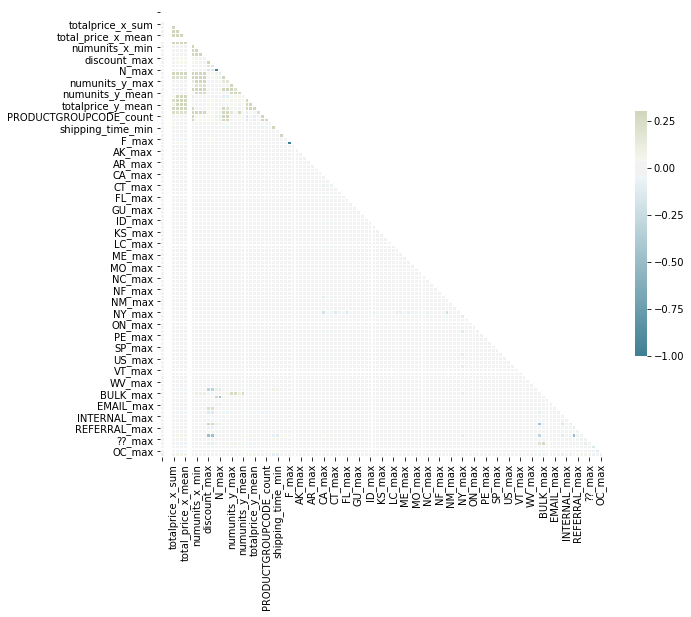

In [37]:
corr = aggregated_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 9))
cmap = sns.diverging_palette(220, 100, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.05, cbar_kws={"shrink": .5})

Już na pierwszy rzut oka widać na wykresie istnienie korelacji części zmiennych. Postanowiono przyjrzeć się korelacji dokładniej poprzez analizę macierzy korelacji.

Aby wyświetlić całą macierz, zmieniono ustawienia biblioteki pandas.

In [38]:
pd.set_option('display.max_rows', 1000)  # or 1000

In [39]:
corr = aggregated_df.corr()
corr.round(decimals=1)

,,orderid_count,campaignid_count,totalprice_x_sum,totalprice_x_min,totalprice_x_max,total_price_x_mean,numorderlines_count,numunits_x_count,numunits_x_min,...,MAIL_max,PARTNER_max,REFERRAL_max,SURVEY_max,WEB_max,??_max,DB_max,MC_max,OC_max,active
,1.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,-0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.1
orderid_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaignid_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
totalprice_x_sum,0.0,NaN,NaN,1.0,0.6,0.6,0.6,NaN,0.4,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
totalprice_x_min,0.0,NaN,NaN,0.6,1.0,1.0,1.0,NaN,0.3,0.0,...,-0.0,0.0,-0.0,-0.0,0.1,-0.0,-0.1,-0.0,-0.0,0.1
totalprice_x_max,0.0,NaN,NaN,0.6,1.0,1.0,1.0,NaN,0.3,0.0,...,-0.0,0.0,-0.0,-0.0,0.1,-0.0,-0.1,-0.0,-0.0,0.1
total_price_x_mean,0.0,NaN,NaN,0.6,1.0,1.0,1.0,NaN,0.3,0.0,...,-0.0,0.0,-0.0,-0.0,0.1,-0.0,-0.1,-0.0,-0.0,0.1
numorderlines_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numunits_x_count,0.0,NaN,NaN,0.4,0.3,0.3,0.3,NaN,1.0,0.3,...,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0
numunits_x_min,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.3,1.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0


Utworzono nową tabelę zawierającą stare zmienne z uwzględnieniem usunięcia tych, które uznano za silnie skorelowane z innymi.

In [40]:
agg_df_2 = aggregated_df.drop(columns = 
    ['totalprice_x_min',
    'total_price_x_mean',
    'numunits_x_count',
    'PARTNER_max',
    'discount_mean',
    'orderlineid_count',
    'numunits_y_sum',
    'numunits_x_mean',
    'numunits_x_min',
    'totalprice_x_max'])

In [41]:
X = agg_df_2.iloc[:,1:-1]
y = agg_df_2['active']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
xgb = XGBClassifier()
model = xgb.fit(X_train, y_train)
pred = model.predict(X_test)
auc=roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) # auc - Pole pod krzywą
print('Współczynnik Giniego: ', auc*2 - 1) #Gini 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Współczynnik Giniego:  0.7219855208551196


Utworzenie nowego modelu poprawiło odrobinę moc predykcyjną, jednak nieistotnie. Wartość współczynnika Giniego wzrosła do 0.722.

# 5. Podsumowanie

Po odpowiednim przygotowaniu danych udało się stworzyć zamierzony model predykcyjny. Jego dopasowanie do danych wynosi 0.722 (według współczynnika Giniego). Oczekiwano lepszego rezultatu, jednak wypracowane rozwiązanie pozwoliłoby w warunkach rynkowych na poprawę ewentualnego mechanizmu marketingowego mającego na celu kierować ofertę do klientów, którzy podejrzani są o zaprzestanie korzystania z usług przedsiębiorstwa w przyszłości.